## Import libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

# Import XGBoost
import xgboost

# XGBoost Classifier
from xgboost import XGBClassifier

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Yahoo finance to get the data
from pandas_datareader import data

# To plot the graphs
import matplotlib.pyplot as plt
import seaborn as sn

# For data manipulation
import pandas as pd
import numpy as np

## Define parameters

We have define the list of stock, start date and the end date which we will be working with in this blog.

In [52]:
# Set the stock list
stock_list = ['AAPL', 'AMZN', 'NFLX', 'NVDA','MSFT']

# Set the start date and the end date
start_date = '2004-1-1'
end_date = '2020-5-22' #'2020-1-28'

## Get the data, create predictors and target variable

In [53]:
# Create a placeholder to store the stock data
stock_data_dictionary = {}

for stock_name in stock_list:
    
    # Get the data    
    df = data.get_data_yahoo(stock_name, start_date, end_date)
    
    # Calculate the daily percent change
    df['daily_pct_change'] = df['Adj Close'].pct_change()

    # create the predictors
    predictor_list = []
    for r in range(10, 60, 5):
        df['pct_change_'+str(r)] = df.daily_pct_change.rolling(r).sum()
        df['std_'+str(r)] = df.daily_pct_change.rolling(r).std()
        predictor_list.append('pct_change_'+str(r))
        predictor_list.append('std_'+str(r))

    # Target Variable
    df['return_next_day'] = df.daily_pct_change.shift(-1)
    df['actual_signal'] = np.where(df.return_next_day > 0, 1, -1)

    df = df.dropna()

    # Add the data to dictionary
    stock_data_dictionary.update({stock_name: df})

In [54]:
stock_data_dictionary['AAPL']

,High,Low,Open,Close,Volume,Adj Close,daily_pct_change,pct_change_10,std_10,pct_change_15,...,pct_change_40,std_40,pct_change_45,std_45,pct_change_50,std_50,pct_change_55,std_55,return_next_day,actual_signal
Date,,,,,,,,,,,,,,,,,,,,,
2004-03-22,0.467321,0.450893,0.453036,0.461786,419031200.0,0.395125,0.000000,-0.002554,0.025135,0.080287,...,0.147178,0.023226,0.134764,0.022306,0.115059,0.023330,0.205783,0.023420,-0.022042,-1
2004-03-23,0.464286,0.450357,0.462143,0.451607,385515200.0,0.386416,-0.022042,-0.066903,0.020909,0.066988,...,0.105190,0.023420,0.118412,0.022582,0.108429,0.023451,0.187953,0.023654,0.008304,1
2004-03-24,0.459821,0.451250,0.451250,0.455357,428215200.0,0.389624,0.008304,-0.080002,0.019302,0.070672,...,0.110886,0.023437,0.126276,0.022595,0.084993,0.023079,0.154433,0.023071,0.053725,1
2004-03-25,0.480536,0.462321,0.466786,0.479821,566445600.0,0.410557,0.053725,-0.007129,0.026891,0.072558,...,0.188452,0.024369,0.185280,0.023795,0.122284,0.024143,0.211767,0.024050,0.006327,1
2004-03-26,0.488571,0.480536,0.482143,0.482857,419893600.0,0.413154,0.006327,-0.015904,0.026457,0.016087,...,0.187674,0.024368,0.210625,0.023534,0.125293,0.024149,0.195459,0.023914,0.032175,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-15,76.974998,75.052498,75.087502,76.927498,41587100.0,76.656792,-0.005912,0.074468,0.013812,0.096808,...,0.260288,0.032241,0.263277,0.041062,0.109441,0.044737,0.184145,0.045250,0.023561,1
2020-05-18,79.125000,77.580002,78.292503,78.739998,33843100.0,78.462914,0.023561,0.083880,0.014616,0.119662,...,0.347334,0.030273,0.167030,0.037328,0.146283,0.044780,0.208291,0.045328,-0.005778,-1
2020-05-19,79.629997,78.252502,78.757500,78.285004,25432400.0,78.009521,-0.005778,0.063093,0.015042,0.130093,...,0.362800,0.029978,0.289898,0.031459,0.219596,0.043212,0.109412,0.043650,0.019448,1


Plot the close returns of Apple.

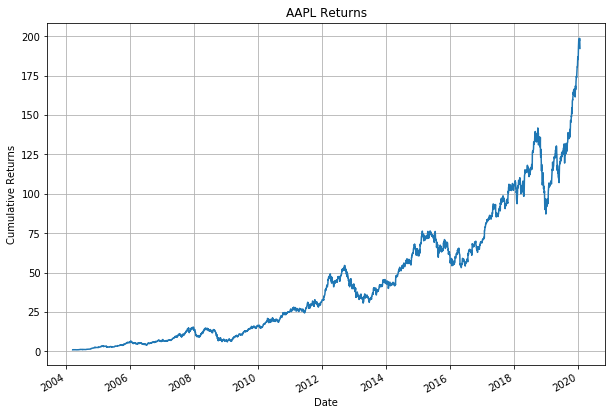

In [6]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Access the dataframe of AAPL from the dictionary 
# and then compute and plot the returns
(stock_data_dictionary['AAPL'].daily_pct_change+1).cumprod().plot()

# Set the title and axis lables and plot grid
plt.title('AAPL Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

## Split the data into train and test

In [7]:
# Create a placeholder for the train and test split data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()

for stock_name in stock_list:
    # Get predictor variables
    X = stock_data_dictionary[stock_name][predictor_list]
    
    # Get the target variable
    y = stock_data_dictionary[stock_name].actual_signal

    # Divide the dataset into train and test
    train_length = int(len(X)*0.80)
    X_train = X_train.append(X[:train_length])
    X_test = X_test.append(X[train_length:])
    y_train = y_train.append(y[:train_length])
    y_test = y_test.append(y[train_length:])

In [8]:
# Initialize the model and set the hyperparameter values
model = XGBClassifier(max_depth=2, n_estimators=30)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Cross Validation in Train dataset

In [9]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5, random_state=7)

# Perform K-Fold Cross Validation
results = cross_val_score(model, X_train, y_train, cv=kfold)

# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 50.85% (0.46%)


## Create the model

In [10]:
# Fit the model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Feature Importance

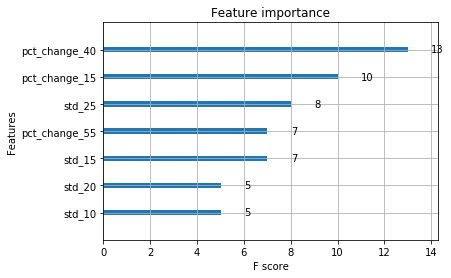

In [11]:
# Plot the top 7 features
xgboost.plot_importance(model, max_num_features=7)

# Show the plot
plt.show()

## Predict

In [12]:
# Predict the trading signal on test datset
y_pred = model.predict(X_test)

## Classification Report

In [13]:
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.46      0.12      0.19      1819
           1       0.54      0.89      0.68      2171

    accuracy                           0.54      3990
   macro avg       0.50      0.50      0.43      3990
weighted avg       0.51      0.54      0.45      3990



## Confusion Matrix

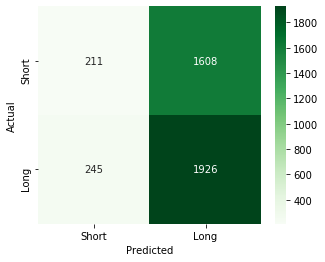

In [14]:
array = confusion_matrix(y_test, y_pred)

df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
                  'Short', 'Long'])

plt.figure(figsize=(5, 4))
sn.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Individual stock performance

AAPL


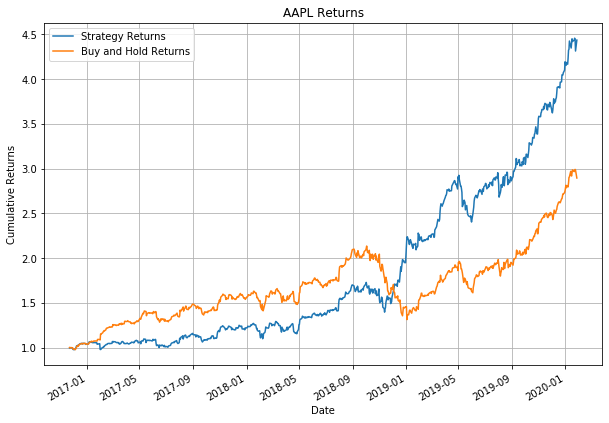

AMZN


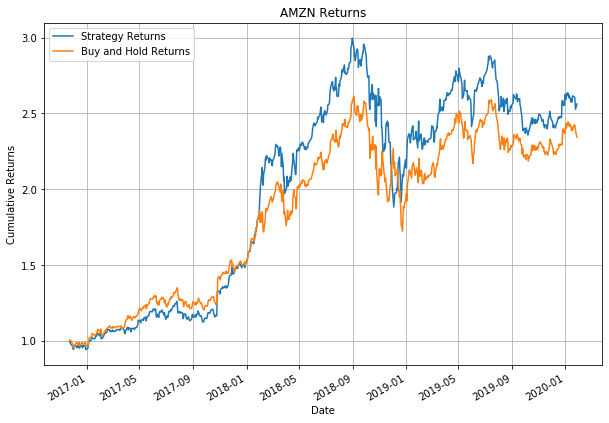

NFLX


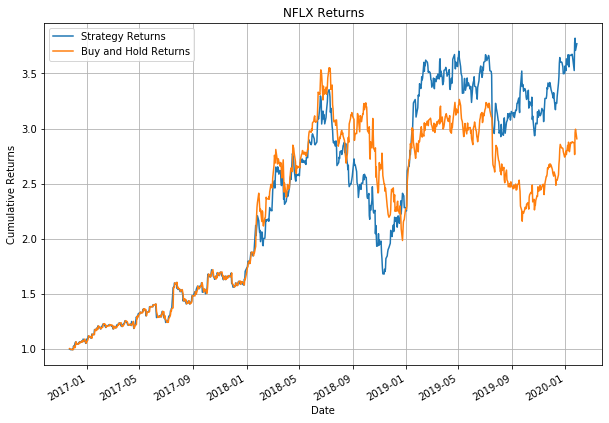

NVDA


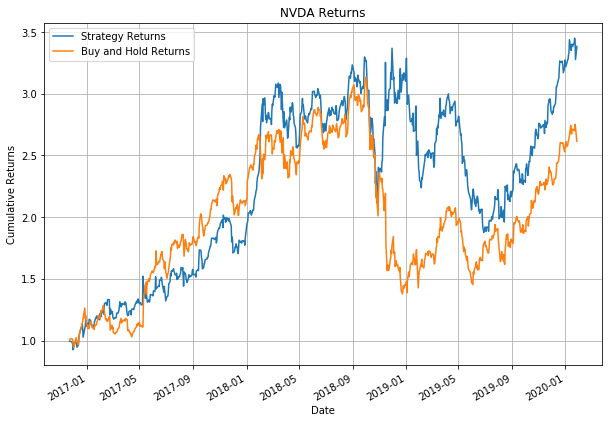

MSFT


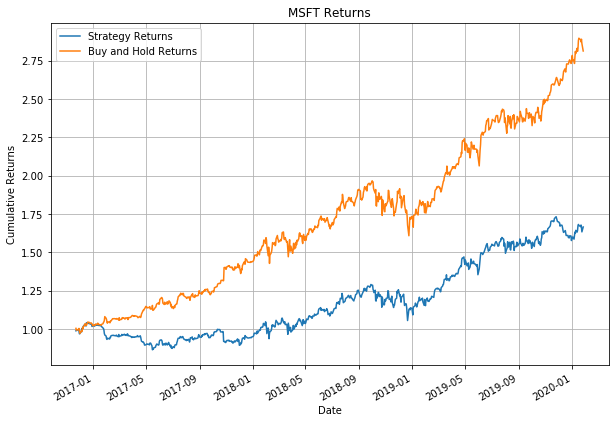

In [15]:
# Create an empty dataframe to store the strategy returns of individual stocks
portfolio = pd.DataFrame(columns=stock_list)

# For each stock in the stock list, plot the strategy returns and buy and hold returns
for stock_name in stock_list:
    
    # Get the data
    df = stock_data_dictionary[stock_name]
    # Store the predictor variables in X
    X = df[predictor_list]

    # Define the train and test dataset
    train_length = int(len(X)*0.80)
    
    # Predict the signal and store in predicted signal column
    df['predicted_signal'] = model.predict(X)
    
    # Calculate the strategy returns
    df['strategy_returns'] = df.return_next_day * df.predicted_signal

    # Add the strategy returns to the portfolio dataframe
    portfolio[stock_name] = df.strategy_returns[train_length:]
    
    # Plot the stock strategy and buy and hold returns
    print(stock_name)
    
    # Set the figure size
    plt.figure(figsize=(10, 7))
    
    # Calculate the cumulative strategy returns and plot
    (df.strategy_returns[train_length:]+1).cumprod().plot()
    
    # Calculate the cumulative buy and hold strategy returns
    (stock_data_dictionary[stock_name][train_length:].daily_pct_change+1).cumprod().plot()    
    
    # Set the title, label and grid
    plt.title(stock_name + ' Returns')
    plt.ylabel('Cumulative Returns')
    plt.legend(labels=['Strategy Returns', 'Buy and Hold Returns'])
    plt.grid()
    plt.show()

## Performance of portfolio

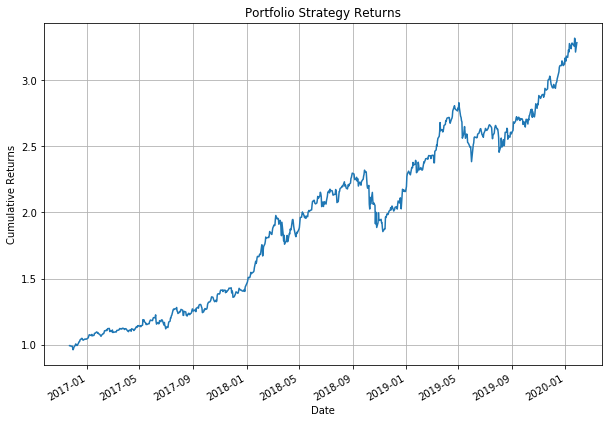

In [16]:
# Drop missing values
portfolio.dropna(inplace=True)

# Set the figure size
plt.figure(figsize=(10, 7))

# Calculate the cumulative portfolio returns by assuming equal allocation to the stocks
(portfolio.mean(axis=1)+1).cumprod().plot()

# Set the title and label of the chart
plt.title('Portfolio Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()

## Detailed performance analysis in test dataset

In [39]:
import pyfolio as pf
pf.create_full_tear_sheet(portfolio['AAPL'],benchmark_rets=portfolio['AMZN'],live_start_date='2018-01-01')#portfolio.mean(axis=1)

Entire data start date: 2016-11-23
Entire data end date: 2020-01-27
In-sample months: 13
Out-of-sample months: 24


,In-sample,Out-of-sample,All
Annual return,20.4%,86.9%,60.4%
Cumulative returns,22.6%,263.5%,345.8%
Annual volatility,17.3%,27.2%,24.2%
Sharpe ratio,1.16,2.44,2.07
Calmar ratio,2.30,4.52,3.14
Stability,0.68,0.96,0.91
Max drawdown,-8.9%,-19.2%,-19.2%
Omega ratio,1.23,1.54,1.46
Sortino ratio,1.64,3.99,3.30
Skew,-0.62,0.35,0.30


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

In [36]:
portfolio.index=pd.to_datetime(portfolio.index).tz_localize('Hongkong')

In [57]:
portfolio['AAPL'].dtype

dtype('float64')

,AAPL,AMZN,NFLX,NVDA,MSFT
Date,,,,,
2016-11-22 00:00:00+08:00,-0.005098,-0.006634,-0.002965,-0.004919,-0.011780
2016-11-23 00:00:00+08:00,0.005035,0.000320,-0.002379,-0.002022,0.002152
2016-11-25 00:00:00+08:00,-0.001968,-0.017428,-0.004088,0.000531,0.001322
2016-11-28 00:00:00+08:00,-0.000986,-0.005543,0.004960,-0.009138,0.007920
2016-11-29 00:00:00+08:00,-0.008434,-0.015672,-0.004340,-0.011260,-0.013586
...,...,...,...,...,...
2020-01-21 00:00:00+08:00,0.003570,-0.002400,-0.035817,0.008752,-0.004805
2020-01-22 00:00:00+08:00,0.004816,-0.001526,0.072393,0.010995,0.006156
2020-01-23 00:00:00+08:00,-0.002882,-0.012172,0.010183,-0.009412,-0.010077
